# How to run clay over custom AOIs

This script shows in a few simple steps how the clay model can be run for custom AOIs and over custom date ranges.

## Download and open global list of MGRS tiles

In [3]:
import os
from pathlib import Path

# The repo home is our working directory.
wd = Path.cwd().parent
os.chdir(wd)
# Ensure data directories exist
Path("data/mgrs").mkdir(exist_ok=True)
Path("data/chips").mkdir(exist_ok=True)
Path("data/checkpoints").mkdir(exist_ok=True)
Path("data/embeddings").mkdir(exist_ok=True)

In [4]:
# get the MGRS grid
mgrs_file = Path("data/mgrs/mgrs_full.fgb")
if not mgrs_file.exists():
    print("Downloading MGRS grid...")
    !wget https://clay-mgrs-samples.s3.amazonaws.com/mgrs_full.fgb \
        -O data/mgrs/mgrs_full.fgb
    print("Done.")

In [5]:
import geopandas as gpd

mgrs = gpd.read_file("data/mgrs/mgrs_full.fgb")
print(f"Loaded {len(mgrs)} MGRS grid cells.")

Loaded 56686 MGRS grid cells.


## Create a Geopandas dataframe with AOI

> You can specify a geojson of a Point or Polygon. 

This example uses a string with a point Cartagena del Chairá, Caquetá, Colombia.

In [6]:
aoi_src = """{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          -74.83924144314427,
          1.3859338719427114
        ],
        "type": "Point"
      }
    }
  ]
}"""
aoi = gpd.read_file(aoi_src, driver="GeoJSON")

## Intersect the AOI with the MGRS tile layer

This will select the MGRS tiles that intersect with your AOI. The whole tile will be downloaded. Adjacent MGRS tiles do also overlap in most cases, so you will download some data that is not in your AOI.


Store the intersected tiles in a file, it will be used by the `datacube.py` script.

In [7]:
mgrs_aoi = mgrs.sjoin(aoi)
mgrs_aoi = mgrs_aoi.rename(columns={"Name": "name"}).reset_index(drop=True)

Number of MGRS tiles covering AOI: 1
Area of AOI: 0.00 sq km
Area of MGRS tiles covering AOI: 12152.40 sq km
Percentage of AOI covered by MGRS tiles: inf%


/tmp/ipykernel_40633/1574953131.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Percentage of AOI covered by MGRS tiles: {100*mgrs_area/aoi_area:.2f}%")
/tmp/ipykernel_40633/1574953131.py:20: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(aoi.to_crs(epsg=3857).geometry.centroid.x)
/tmp/ipykernel_40633/1574953131.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(aoi.to_crs(epsg=3857).geometry.centroid.y)


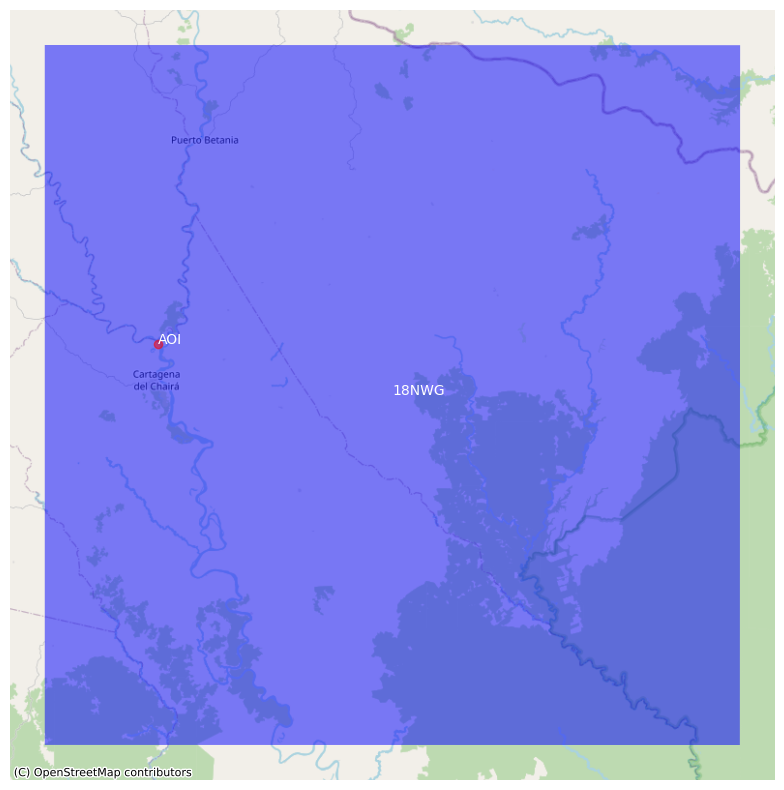

In [8]:
import contextily as ctx
import matplotlib.pyplot as plt

# print number of mgrs_aoi, and the area of the aoi and mgrs_aoi
print(f"Number of MGRS tiles covering AOI: {len(mgrs_aoi)}")
aoi_area = aoi.to_crs(epsg=3857).area[0] / 1e6
mgrs_area = mgrs_aoi.to_crs(epsg=3857).area.sum() / 1e6
print(f"Area of AOI: {aoi_area:.2f} sq km")
print(f"Area of MGRS tiles covering AOI: {mgrs_area:.2f} sq km")
print(f"Percentage of AOI covered by MGRS tiles: {100*mgrs_area/aoi_area:.2f}%")


fig, ax = plt.subplots(figsize=(10, 10))
mgrs_aoi.to_crs(epsg=3857).plot(ax=ax, color="blue", alpha=0.5, label="MGRS")
for idx, row in mgrs_aoi.to_crs(epsg=3857).iterrows():
    x = float(row.geometry.centroid.x)
    y = float(row.geometry.centroid.y)
    ax.annotate(text=row["name"], xy=(x, y), color="white")
aoi.to_crs(epsg=3857).plot(ax=ax, color="red", alpha=0.5, label="AOI")
x = float(aoi.to_crs(epsg=3857).geometry.centroid.x)
y = float(aoi.to_crs(epsg=3857).geometry.centroid.y)
ax.annotate(text="AOI", xy=(x, y), color="white")
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.show()

In [9]:
mgrs_aoi.to_file("data/mgrs/mgrs_aoi.fgb")
mgrs_aoi.head()

,name,geometry,index_right
0,18NWG,"MULTIPOLYGON (((-75.00018 1.80982, -74.01299 1...",0


## Time range

Just like we specified the AOI, we can specify a time range. The time ranges will be used to find sets of dataset on each source that are within 3 days of each other.


In [10]:
time_ranges = ["2020-01-01/2020-06-30",
               "2020-07-01/2020-12-31",
               "2021-01-01/2021-06-30",
               "2021-07-01/2021-12-31",
               "2022-01-01/2022-06-30",
               "2022-07-01/2022-12-31",
               "2023-01-01/2023-06-30",
               "2022-07-01/2023-12-31"]
#has to be a string
time_ranges = ",".join(time_ranges)
time_ranges


'2020-01-01/2020-06-30,2020-07-01/2020-12-31,2021-01-01/2021-06-30,2021-07-01/2021-12-31,2022-01-01/2022-06-30,2022-07-01/2022-12-31,2023-01-01/2023-06-30,2022-07-01/2023-12-31'

## Use the datacube.py script to download imagery

Each run of th datacube script will take an index as input, which is the index of the geometry within the input file. This is why we need to download the data in a loop.

A list of date ranges can be specified. The script will look for the least cloudy Sentinel-2 scene for each date range, and match Sentinel-1 dates near the identified Sentinel-2 dates.

The output folder can be specified as a local folder, or a bucket can be specified to upload the data to S3.

Note: You may need to setup a Planetary Computer access key. Get in on the [PC developer portal](https://planetarycomputer.developer.azure-api.net/) and set it with 
```bash
planetarycomputer configure
```

In the example below, we limit data volume to a pixel window of 1024x1024 pixels to speed up processing. With the subsetting, this should provide up to 4 image "chips" per MGRS tile and date range, depending on data availability. Remove the subset argument for a real use case, where all the data should be downloaded.

In [11]:
for index, row in mgrs_aoi.iterrows():
    print(index)
    ! python scripts/datacube.py \
        --sample data/mgrs/mgrs_aoi.fgb \
        --localpath data/chips  \
        --index {index} \
        --dateranges {time_ranges}


0
Starting algorithm for MGRS tile 18NWG with index 0
Processing data for date range 2020-01-01/2020-06-30
Found 7 Sentinel-2 items
EPSG code based on Sentinel-2 item:  32618
Searching S1 in date range 2020-01-01/2020-01-07
Found 4 Sentinel-1 items
Most overlapped orbit:  descending
Found 4 DEM items
/home/brunosan/miniforge3/envs/claymodel/lib/python3.11/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(
/home/brunosan/miniforge3/envs/claymodel/lib/python3.11/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsi

## Create the embeddings for each training chip

The checkpoints can be downloaded from huggingface.

In [12]:
model_file = Path("data/checkpoints/Clay_v0.1_epoch-24_val-loss-0.46.ckpt")
model_url = "https://huggingface.co/made-with-clay/Clay/resolve/main/Clay_v0.1_epoch-24_val-loss-0.46.ckpt"
if not model_file.exists():
    print("Downloading model...")
    !wget $model_url \
        -O $model_file
    print("Done.")

After downloading the model weights, embeddings can be created with just one command.

In [13]:
! wandb disabled
! python trainer.py predict \
    --ckpt_path=data/checkpoints/Clay_v0.1_epoch-24_val-loss-0.46.ckpt \
    --trainer.precision=16-mixed \
    --data.data_dir=data/chips

W&B disabled.
Seed set to 42
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[rank: 0] Seed set to 42
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------

Total number of chips: 1102
Restoring states from the checkpoint path at data/checkpoints/Clay_v0.1_epoch-24_val-loss-0.46.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at data/checkpoints/Clay_v0.1_epoch-24_val-loss-0.46.ckpt
Predicting DataLoader 0:   0%|                          | 0/111 [00:00<?, ?it/s]/home/brunosan/miniforge3/envs/claymodel/lib/python3.11

You should see your embeddings files in the folder `data/embeddings`. 

> Note that `chips` are stored one per file (many per MGRS tile), but `embeddings` are stored in a single file per MGRS tile. See [Documentation](https://clay-foundation.github.io/model/model_embeddings.html).


In [16]:
import numpy as np
import openTSNE
import pandas as pd

# Load the embeddings
clay = pd.read_pickle("docs/clay_embeddings.pkl")

In [20]:
x = np.array(clay["embeddings"].tolist())
t= openTSNE.TSNE(
    metric='cosine',
    n_jobs=-1,
    verbose=3
).fit(x)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, metric='cosine', n_jobs=-1, verbose=3)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 0.09 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.02 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=12.00, lr=91.83 for 250 iterations...
Iteration   50, KL divergence 2.7639, 50 iterations in 21.0425 sec
Iteration  100, KL divergence 2.7841, 50 iterations in 18.6684 sec
Iteration  150, KL divergence 2.7830, 50 iterations in 17.7555 sec
Iteration  200, KL divergence 2.7830, 50 iterations in 17.7803 sec
Iteration  250, KL divergence 2.7829, 50 iterations in 17.6352 sec
   --> Time elapsed: 92.88 seconds
===> Running optimization with exaggeration=1.

In [35]:
clay["x"] = t[:, 0]
clay["y"] = t[:, 1]
clay["stem"] = clay["source_url"].apply(lambda x: Path(x).stem)
clay["rgb_file"] = clay["source_url"].apply(lambda x: "rgbs/" + Path(x).stem + ".jpg")

In [31]:
from sklearn.cluster import KMeans

for n_cluster in [10, 20, 100, 500]:
    print(f"Clustering with {n_cluster} clusters")
    k_means = KMeans(n_clusters=n_cluster, n_init="auto")
    clay[str(n_cluster) + "_clusters"] = k_means.fit_predict(t)



Clustering with 10 clusters
Clustering with 20 clusters
Clustering with 100 clusters
Clustering with 500 clusters


Saving rgbs/claytile_18NWG_20210128_v02_0081.jpg


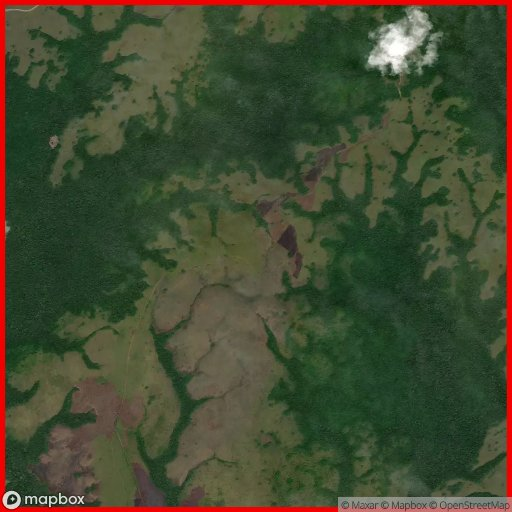

In [32]:
from pathlib import Path

from PIL import Image

import json
from urllib.parse import quote

import requests


def reduce_precision(coordinates, precision=2):
    """
    Reduce the precision of coordinates.
    Needed for Mapbox API requests.
    """
    if isinstance(coordinates[0], (list, tuple)):
        return [reduce_precision(coord, precision) for coord in coordinates]
    else:
        return round(coordinates[0], precision), round(coordinates[1], precision)


def get_mapbox_image(polygon, access_token):
    """
    Get a satellite image from Mapbox API.
    polygon: shapely.geometry.Polygon
    access_token: Mapbox access token
    """
    try:
        rounded_coords = reduce_precision(list(polygon.exterior.coords))
        geojson = {
            "type": "FeatureCollection",
            "features": [
                {
                    "id": "0",
                    "type": "Feature",
                    "properties": {
                        "stroke": "#f00000",
                        "stroke-width": 10,
                        "stroke-opacity": 1,
                        "fill": "#f00000",
                        "fill-opacity": 0,
                    },
                    "geometry": {"type": "Polygon", "coordinates": [rounded_coords]},
                }
            ],
        }
        encoded_geojson = quote(json.dumps(geojson))
        min_lon, min_lat = min(rounded_coords, key=lambda x: (x[0], x[1]))
        max_lon, max_lat = max(rounded_coords, key=lambda x: (x[0], x[1]))
        mapbox_url = (
            "https://api.mapbox.com/styles/v1/mapbox/satellite-streets-v12/static/"
            + f"geojson({encoded_geojson})"
            + f"/[{min_lon},{min_lat},{max_lon},{max_lat}]/"
            + f"512x512?access_token={access_token}"
        )

        response = requests.get(mapbox_url)

        all_ok = 200
        if response.status_code == all_ok:
            return response.content, None
        else:
            return None, f"Error: {response.status_code}, {response.text}"

    except Exception as e:
        return None, f"Error: {str(e)}"


access_token = os.environ["MAPBOX_token"]

def process_rgb(row):
    """
    From a geoPandas Row,
    return or create an the RGB local image
    from Mapbox API and save it.
    """
    stem = Path(row["source_url"]).stem
    geom = row["geometry"]
    os.makedirs("rgbs", exist_ok=True)
    rgb_file = Path(f"rgbs/{stem}.jpg")
    if rgb_file.is_file():
        print(f"File {rgb_file} already exists.")
        return rgb_file
    image_data, error = get_mapbox_image(geom, access_token)
    # save the image
    if error is None:
        print(f"Saving {rgb_file}")
        with open(rgb_file, "wb") as image_file:
            image_file.write(image_data)
        return rgb_file
    else:
        return f"Error: {error}"


rgb_file = process_rgb(clay.sample(1).to_crs(epsg=4327).iloc[0])
Image.open(rgb_file)


In [36]:
import plotly.graph_objs as go
from IPython.display import Image, clear_output, display
from ipywidgets import HBox, Output

# only use a sample of the data
sample = clay

# Create the scatter plot with colored clusters and titles (tooltips) for each dot
scatter_plot = go.FigureWidget(
    [
        go.Scattergl(
            x=sample["x"],
            y=sample["y"],
            mode="markers",
            marker={"color": sample["20_clusters"], "size": 5, "opacity": 0.5},
            text=sample["stem"],
            hoverinfo="text",
        )
    ]
)

# Create output widgets for the image and possibly additional data with fixed height
image_output = Output(layout={"height": "512px"})


# Function to handle click events
def display_image(trace, points, selector):
    if points.point_inds:
        idx = points.point_inds[0]
        selected_row = sample.iloc[idx]  # Get the row from the sample DataFrame
        with image_output:
            # Clear the previous image
            clear_output(wait=True)
            print(process_rgb(selected_row))
            img_file = selected_row["rgb_file"]
            if Path(img_file).is_file():
                img = Image(img_file)
                display(img)
            else:
                print("No image available.")


# Bind the click event to the display_image function
scatter = scatter_plot.data[0]
scatter.on_click(display_image)

# Layout: side by side - scatter plot on the left, image on the right
container = HBox([scatter_plot, image_output])
display(container)

    'data': [{'hoverinfo': 'text',
              'marker': {'color': array([10, …